# 0.0 Theory about fuzzy model

**What is a fuzzy model?**  
It deals with "degrees of truth" rather than "true or false". Fuzzy logic is a mathematical framework for representing and reasoning with information that is imprecise, uncertain. It allows to use linguistic like slow, fast, small, large, near, far in a mathematical model.   
  
**How does a fuzzy model work?**  
The model uses a fuzzy logic to map inputs to outputs. It consists of three stages:  
1. **Fuzzification**  
Goal is to convert numerical input like temperature = 22 into fuzzy sets. The membership functions have to be define for each lingustic term (example: cold, warm, hot). A membership function is simply a curve or shape like a triangle that defines how much a given input value belongs to that term on a scale from 0 to 1. For example: cold = 0.1, warm = 0.8, hot = 0.0  
  
2. **Inference, the rule base**  
It uses a set of human-readable IF-THEN rules. These rules are created based on expert knowledge of the domain. Example rules to control fan: 
* If temperature is 'hot' THEN fan_speed is 'fast'
* If temperature is 'warm' THEN fan_speed is 'medium' etc.
The system evaluates the strength it means if the temperature is 80% warm, then rule 2 is activated with a strength of 0.8  
  
3. **Defuzzification** 
Convert the fuzzy output "80% medium" and some influence from other rules nto a single numerical output that machine can use. It combines the results of all the adctivated rules into a single fuzzy set. Centroid method is popular, which finds the center of the combined shape. This is essentially a weighted average. 
  
**Pros and cons of fuzzy model**  
* Fuzzy logic allows yo create a very good model using approximate, linguistic rules without needing a perfect formula.  
* It can works  with noisy data  
* It is more intuitive for human

# 1.0 Analytical results

In [180]:
import numpy as np 
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Given parameters
D = 10 # Range of throw
ALPHA = np.deg2rad(45) # Launch angle
K = 0.001 # Drag coefficient
M = 0.1 # mass
G = 10 # gravity

![Compare results](examples.PNG)

## 1.1 Simple version 

In [181]:
def calculate_v0(d, alpha, g):
    return np.sqrt((d*g)/np.sin(2*alpha))

calculate_v0(D, ALPHA, G)

np.float64(10.0)

## 1.2 Less simple version 

In [182]:
from scipy.special import lambertw

def v0_analytical(d, alpha, k, m, g, branch=0):
    """Analytical solution for v0 given range d, launch angle alpha, drag koefficient k, mass m and gravity g"""

    beta = k / m
    arg = -np.exp(-1 - (beta**2 * d / g) * np.tan(alpha))
    W = lambertw(arg, branch)
    u = 1 + W
    v0 = beta * d / (np.cos(alpha) * u.real)
    return v0


v0_analytical(D, ALPHA, K, M, G)

np.float64(10.047307538241881)

## 1.3 Three cases for later comparison 

In [183]:
# x_ranges = [10, 8.33, 3.13]
x_ranges = [20, 50, 130]
y_v0_for_three_ranges = [v0_analytical(x, ALPHA, K, M, G) for x in x_ranges]

print(f"For desired range:\n{x_ranges[0]} we need v0:{y_v0_for_three_ranges[0]:.2f}\n{x_ranges[1]} we need v0: {y_v0_for_three_ranges[1]:.2f}\n{x_ranges[2]} we need v0: {y_v0_for_three_ranges[2]:.2f}")

For desired range:
20 we need v0:14.24
50 we need v0: 22.60
130 we need v0: 36.68


# 2.0 Fuzzy model

## 2.1 Variables and memberships

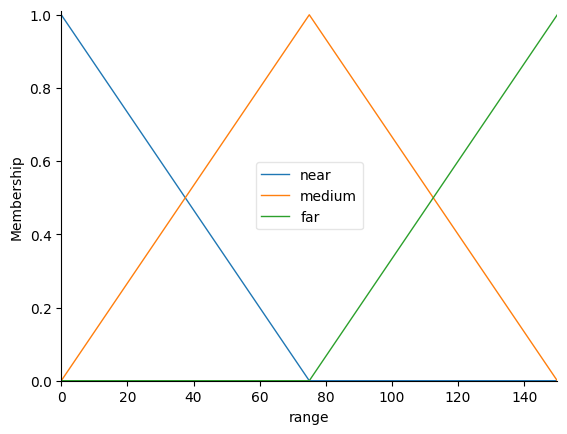

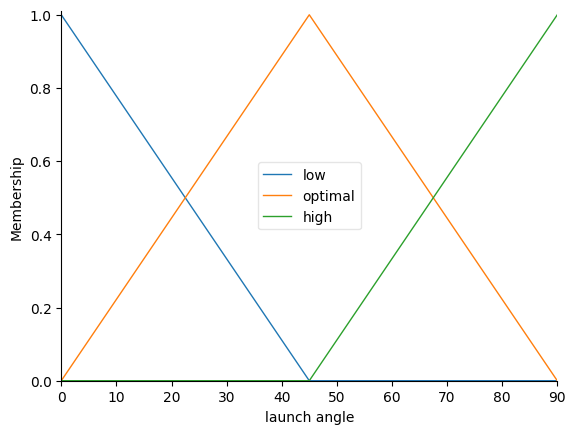

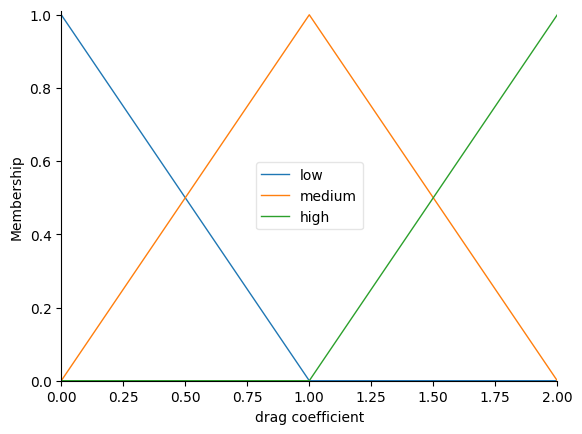

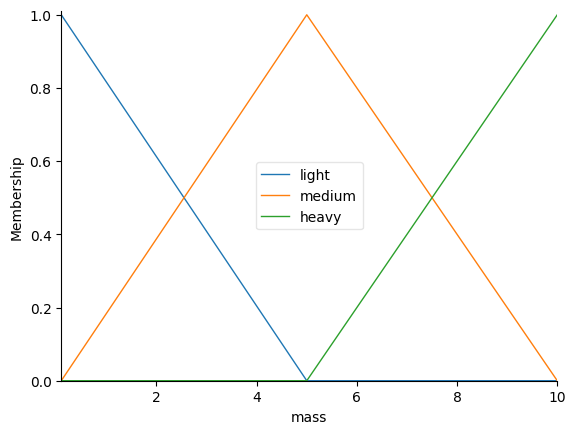

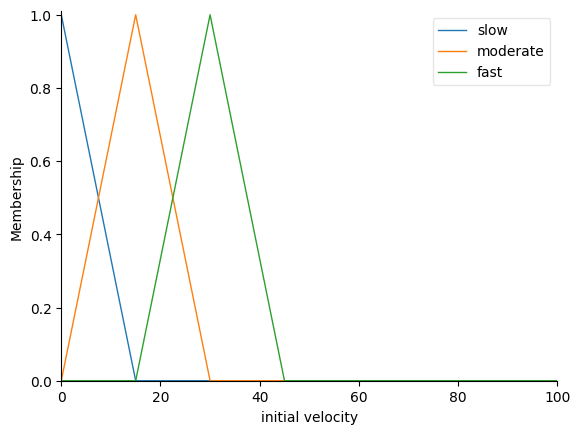

In [184]:
import numpy as np
import skfuzzy.control as ctrl
import skfuzzy as fuzz

# Creating variables for our problem
range_d = np.arange(0, 151, 1)
launch_angle_alpha = np.arange(0, 91, 1)
drag_coeff_k = np.arange(0, 2.01, 0.01)
mass_m = np.arange(0.1, 10.1, 0.1)
init_velo_v0 = np.arange(0, 101, 1)

# Create the fuzzy input and otput variables
d = ctrl.Antecedent(range_d, 'range') # this label I will use during simulation
alpha = ctrl.Antecedent(launch_angle_alpha, 'launch angle') # this label I will use during simulation
k = ctrl.Antecedent(drag_coeff_k, 'drag coefficient') # this label I will use during simulation
m = ctrl.Antecedent(mass_m, 'mass') # this label I will use during simulation
v0 = ctrl.Consequent(init_velo_v0, 'initial velocity') # this label I will use during simulation

# Define membership functions

d["near"] = fuzz.trimf(range_d, [0, 0, 75])
d["medium"] = fuzz.trimf(range_d, [0, 75, 150])
d["far"] = fuzz.trimf(range_d, [75, 150, 150])

alpha["low"] = fuzz.trimf(launch_angle_alpha, [0, 0, 45])
alpha["optimal"] = fuzz.trimf(launch_angle_alpha, [0, 45, 90])
alpha["high"] = fuzz.trimf(launch_angle_alpha, [45, 90, 90])

k["low"] = fuzz.trimf(drag_coeff_k, [0, 0, 1])
k["medium"] = fuzz.trimf(drag_coeff_k, [0, 1, 2])
k["high"] = fuzz.trimf(drag_coeff_k, [1, 2, 2])

m["light"] = fuzz.trimf(mass_m, [0.1, 0.1, 5])
m["medium"] = fuzz.trimf(mass_m, [0.1, 5, 10])
m["heavy"] = fuzz.trimf(mass_m, [5, 10, 10])

v0["slow"] = fuzz.trimf(init_velo_v0, [0, 0, 15])
v0["moderate"] = fuzz.trimf(init_velo_v0, [0, 15, 30])
v0["fast"] = fuzz.trimf(init_velo_v0, [15, 30, 45])

d.view()
alpha.view()
k.view()
m.view()
v0.view()

## 2.2 Rules

In [185]:
# Rules IF THEN
# How to read them?

# To throw sth heavy far at best angle with low drag I need 'fast' velocity
rule1 = ctrl.Rule(d["far"] & alpha["optimal"] & k["low"] & m["heavy"], v0["fast"]) 

# If desired range is near, velocity could be slow, regardless of conditions
rule2 = ctrl.Rule(d["near"], v0["slow"]) 

# If desired range is far and drag is high, velocity must be faster to compensate
rule3 = ctrl.Rule(d["far"] & k["high"], v0["fast"])

# If desired range is far and  mass is low, velocity needs to be higher
rule4 = ctrl.Rule(d["far"] & m["light"], v0["fast"])

# Average conditions
rule5 = ctrl.Rule(d["medium"] & alpha["optimal"], v0["moderate"])

# If the angle is not optimal, velocity needs to be higher
rule6 = ctrl.Rule(d["medium"] & (alpha['low'] | alpha['high']), v0["fast"])

#rule7 = ctrl.Rule(,v0["moderate"])

## 2.3 Creating system


 For desired range 20, v0 should be: 17.607437447510055

 For desired range 50, v0 should be: 24.355748586974705

 For desired range 130, v0 should be: 29.58102269644213


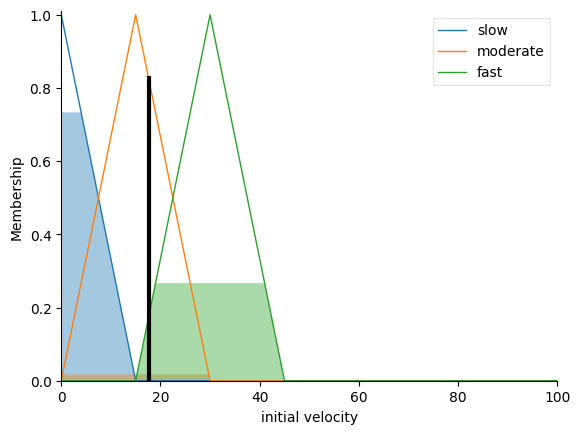

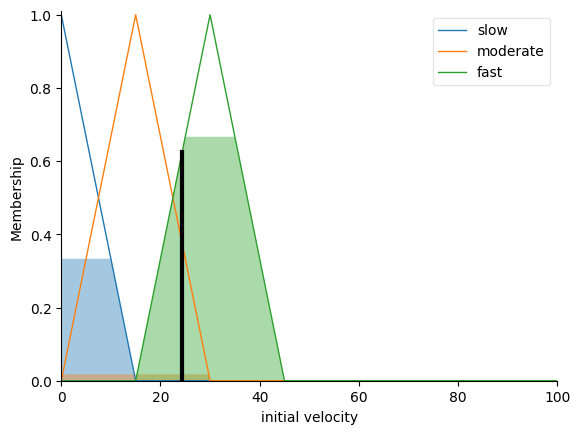

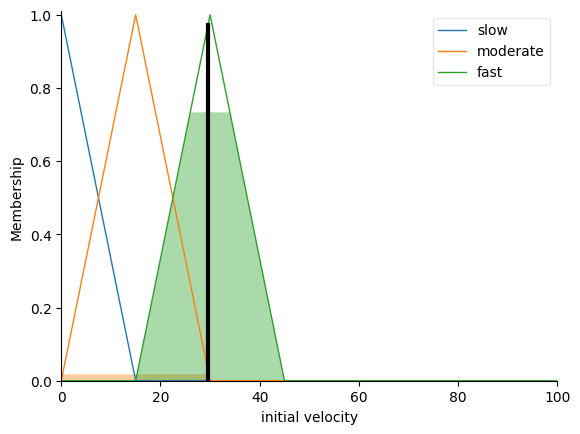

In [186]:
# Create the control system
sys = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

# Create a simulation for our system
sim = ctrl.ControlSystemSimulation(sys)

# List to accumulate results of fuzzy model 
y_fuzzy = []

# provide inputs
for x in x_ranges: # Loop over 3 desired ranges
    sim.input['range'] = x # 10
    sim.input["launch angle"] = ALPHA # 45
    sim.input["drag coefficient"] = K # 0.001
    sim.input["mass"] = M # 0.1

    # Compute results
    sim.compute()

    v0_fuzzy = sim.output["initial velocity"]
    y_fuzzy.append(v0_fuzzy)
    v0.view(sim)

    print(f"\n For desired range {x}, v0 should be: {v0_fuzzy}")

# 3. Compare results

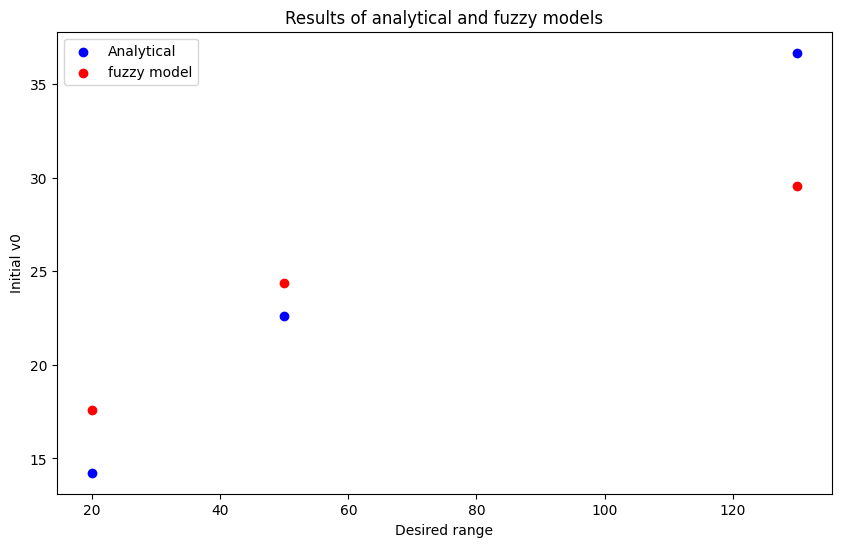

In [187]:

plt.figure(figsize=(10,6))
plt.scatter(x_ranges, y_v0_for_three_ranges, c="blue", label="Analytical")
plt.scatter(x_ranges, y_fuzzy, c="red", label="fuzzy model")
plt.title("Results of analytical and fuzzy models")
plt.xlabel("Desired range")
plt.ylabel("Initial v0")
plt.legend()
plt.show()